In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting up plotting environment
sns.set()
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

# Fetching and preparing the data
data = fetch_401K(return_type='DataFrame')
dtypes = data.dtypes
dtypes['nifa'] = 'float64'
dtypes['net_tfa'] = 'float64'
dtypes['tw'] = 'float64'
dtypes['inc'] = 'float64'
data = data.astype(dtypes)

# Display data info
print(data.head())
print(data.describe())

      nifa  net_tfa        tw  age      inc  fsize  educ  db  marr  twoearn  \
0      0.0      0.0    4500.0   47   6765.0      2     8   0     0        0   
1   6215.0   1015.0   22390.0   36  28452.0      1    16   0     0        0   
2      0.0  -2000.0   -2000.0   37   3300.0      6    12   1     0        0   
3  15000.0  15000.0  155000.0   58  52590.0      2    16   0     1        1   
4      0.0      0.0   58000.0   32  21804.0      1    11   0     0        0   

   e401  p401  pira  hown  
0     0     0     0     1  
1     0     0     0     1  
2     0     0     0     0  
3     0     0     0     1  
4     0     0     0     1  
               nifa       net_tfa            tw          age            inc  \
count  9.915000e+03  9.915000e+03  9.915000e+03  9915.000000    9915.000000   
mean   1.392864e+04  1.805153e+04  6.381685e+04    41.060212   37200.623197   
std    5.490488e+04  6.352250e+04  1.115297e+05    10.344505   24774.288006   
min    0.000000e+00 -5.023020e+05 -5.0230

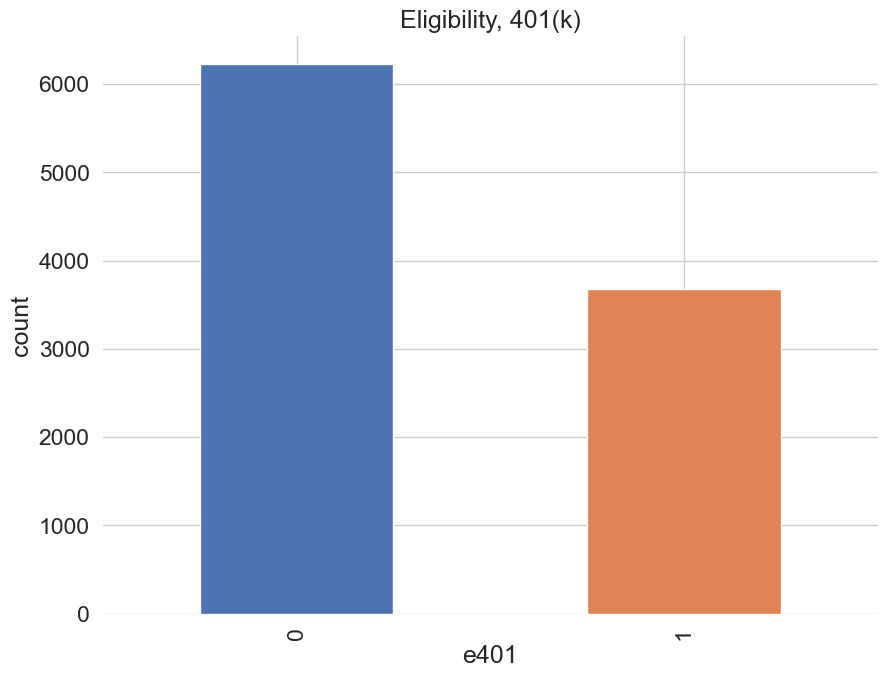

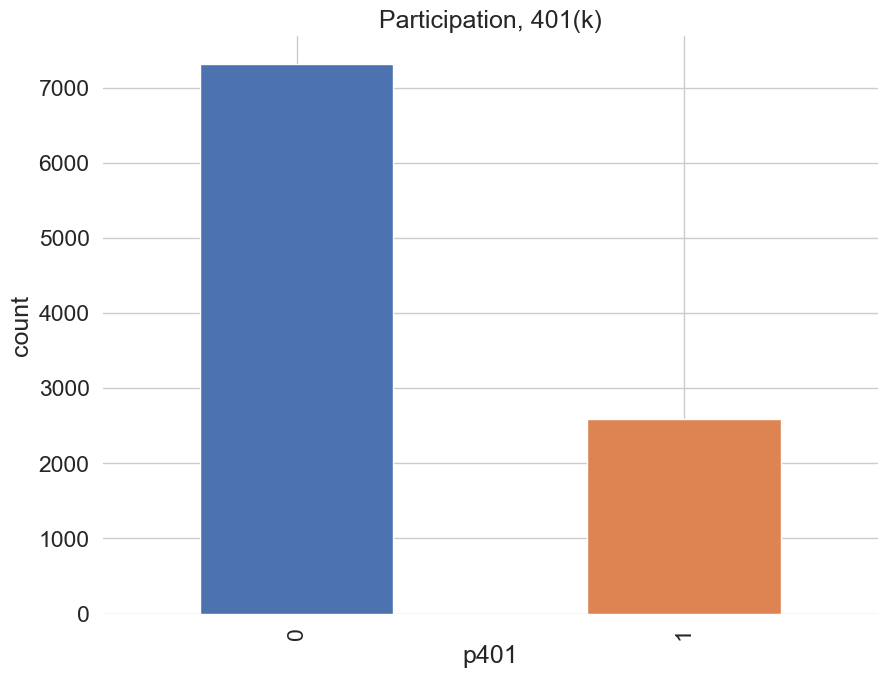

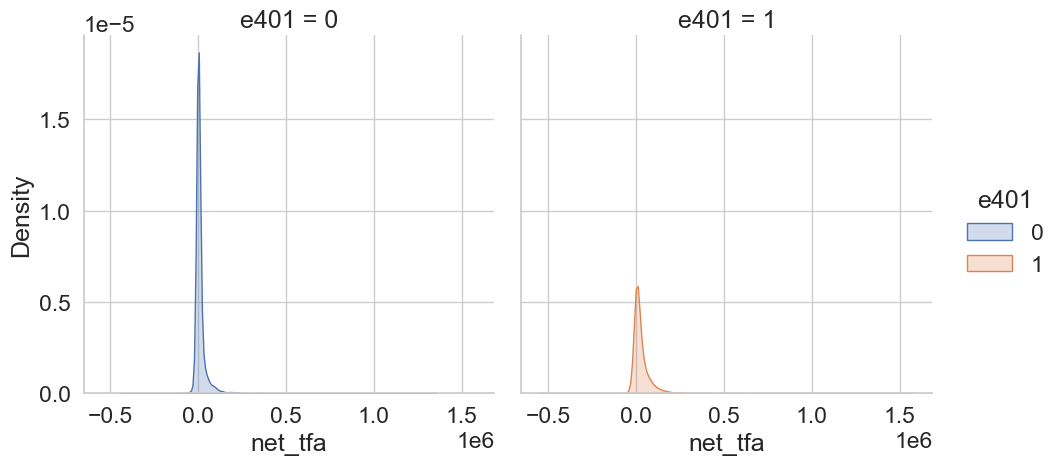

In [3]:
# Plotting
data['e401'].value_counts().plot(kind='bar', color=colors)
plt.title('Eligibility, 401(k)')
plt.xlabel('e401')
plt.ylabel('count')
plt.savefig('Eligibility_401k.png')
plt.show()
plt.close()

data['p401'].value_counts().plot(kind='bar', color=colors)
plt.title('Participation, 401(k)')
plt.xlabel('p401')
plt.ylabel('count')
plt.savefig('Participation_401k.png')
plt.show()
plt.close()

sns.displot(data, x="net_tfa", hue="e401", col="e401", kind="kde", fill=True)
plt.savefig('Net_TFA_Distribution.png')
plt.show()
plt.close()

In [4]:
print(data[['e401', 'net_tfa']].groupby('e401').mean().diff())
print(data[['p401', 'net_tfa']].groupby('p401').mean().diff())

          net_tfa
e401             
0             NaN
1     19559.34475
           net_tfa
p401              
0              NaN
1     27371.583404


In [5]:
# Basic
features_base = ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
data_dml_base = dml.DoubleMLData(data, y_col='net_tfa', d_cols='e401', x_cols=features_base)
data_dml_base_iv = dml.DoubleMLData(data, y_col='net_tfa', d_cols='p401', z_cols='e401', x_cols=features_base)

# Flexible
features = data.copy()[['marr', 'twoearn', 'db', 'pira', 'hown']]
poly_dict = {'age': 2, 'inc': 2, 'educ': 2, 'fsize': 2}
for key, degree in poly_dict.items():
    poly = PolynomialFeatures(degree, include_bias=False)
    data_transf = poly.fit_transform(data[[key]])
    x_cols = poly.get_feature_names_out([key])
    data_transf = pd.DataFrame(data_transf, columns=x_cols)
    features = pd.concat((features, data_transf), axis=1, sort=False)
model_data = pd.concat((data.copy()[['net_tfa', 'e401']], features.copy()), axis=1, sort=False)
data_dml_flex = dml.DoubleMLData(model_data, y_col='net_tfa', d_cols='e401')

model_data = pd.concat((data.copy()[['net_tfa', 'e401', 'p401']], features.copy()), axis=1, sort=False)
data_dml_flex_iv = dml.DoubleMLData(model_data, y_col='net_tfa', d_cols='p401', z_cols='e401')

print(data_dml_base)
print(data_dml_flex)
print(data_dml_base_iv)
print(data_dml_flex_iv)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float64(4), int8(10)
memory usage: 406.8 KB

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['marr', 'twoearn', 'db', 'pira', 'hown', 'age', 'age^2', 'inc', 'inc^2', 'educ', 'educ^2', 'fsize', 'fsize^2']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 

In [6]:
# Initialize learners
Cs = 0.0001*np.logspace(0, 4, 10)
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000))
lasso_class = make_pipeline(StandardScaler(), LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', Cs=Cs, max_iter=1000))

randomForest = RandomForestRegressor(n_estimators=500, max_depth=7, max_features=3, min_samples_leaf=3)
randomForest_class = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=4, min_samples_leaf=7)

trees = DecisionTreeRegressor(max_depth=30, ccp_alpha=0.0047, min_samples_split=203, min_samples_leaf=67)
trees_class = DecisionTreeClassifier(max_depth=30, ccp_alpha=0.0042, min_samples_split=104, min_samples_leaf=34)

boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror", eta=0.1, n_estimators=35)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1, objective = "binary:logistic", eval_metric = "logloss", eta=0.1, n_estimators=34)

hist_gb = HistGradientBoostingRegressor(max_iter=500, max_depth=7, max_features=0.4, min_samples_leaf=3)
hist_gb_class = HistGradientBoostingClassifier(max_iter=500, max_depth=5, max_features=0.5, min_samples_leaf=7)

# Models and summaries initialization
plr_summaries, irm_summaries, iivm_summaries = [], [], []

# DoubleMLPLR models
for model_data, model_name in [(data_dml_base, 'base'), (data_dml_flex, 'flex')]:
    for ml_l, ml_m, model_label in [(lasso, lasso_class, 'lasso'), 
                                    (randomForest, randomForest_class, 'forest'), 
                                    (trees, trees_class, 'tree'), 
                                    (boost, boost_class, 'xgboost'), 
                                    (hist_gb, hist_gb_class, 'hist_gb')]:
        np.random.seed(123)
        dml_plr = dml.DoubleMLPLR(model_data, ml_l=ml_l, ml_m=ml_m, n_folds=3)
        dml_plr.fit(store_predictions=True)
        summary = dml_plr.summary
        plr_summaries.append((summary, f"{model_label}_{len(model_data.x_cols)}"))

# DoubleMLIRM models
for model_data, model_name in [(data_dml_base, 'base'), (data_dml_flex, 'flex')]:
    for ml_g, ml_m, model_label in [(lasso, lasso_class, 'lasso'), 
                                    (randomForest, randomForest_class, 'forest'), 
                                    (trees, trees_class, 'tree'), 
                                    (boost, boost_class, 'xgboost'), 
                                    (hist_gb, hist_gb_class, 'hist_gb')]:
        np.random.seed(123)
        dml_irm = dml.DoubleMLIRM(model_data, ml_g=ml_g, ml_m=ml_m, trimming_threshold=0.01, n_folds=3)
        dml_irm.fit(store_predictions=True)
        summary = dml_irm.summary
        irm_summaries.append((summary, f"{model_label}_{len(model_data.x_cols)}"))

# DoubleMLIIVM models
for model_data, model_name in [(data_dml_base_iv, 'base'), (data_dml_flex_iv, 'flex')]:
    for ml_g, ml_m, ml_r, model_label in [(lasso, lasso_class, lasso_class, 'lasso'), 
                                          (randomForest, randomForest_class, randomForest_class, 'forest'), 
                                          (trees, trees_class, trees_class, 'tree'), 
                                          (boost, boost_class, boost_class, 'xgboost'), 
                                          (hist_gb, hist_gb_class, hist_gb_class, 'hist_gb')]:
        np.random.seed(123)
        dml_iivm = dml.DoubleMLIIVM(model_data, ml_g=ml_g, ml_m=ml_m, ml_r=ml_r, subgroups={'always_takers': False, 'never_takers': True}, trimming_threshold=0.01, n_folds=3)
        dml_iivm.fit(store_predictions=True)
        summary = dml_iivm.summary
        iivm_summaries.append((summary, f"{model_label}_{len(model_data.x_cols)}"))


                          coef      std err         t         P>|t|  \
Model ML                                                              
PLR   lasso_9      5722.474846  1380.619177  4.144861  3.400196e-05   
      forest_9     8909.655955  1321.826203  6.740414  1.579359e-11   
      tree_9       8260.064280  1348.624798  6.124805  9.079458e-10   
      xgboost_9    8688.511288  1390.889301  6.246731  4.191320e-10   
      hist_gb_9    8511.948464  1432.407960  5.942405  2.808701e-09   
      lasso_13     8974.791220  1324.323622  6.776887  1.227931e-11   
      forest_13    8950.201779  1328.803228  6.735536  1.633269e-11   
      tree_13      8260.064280  1348.624798  6.124805  9.079458e-10   
      xgboost_13   8474.382598  1405.702036  6.028577  1.654099e-09   
      hist_gb_13   9015.301486  1426.276618  6.320865  2.601037e-10   
IRM   lasso_9      4124.840225  1568.054257  2.630547  8.524761e-03   
      forest_9     8169.468767  1108.834442  7.367618  1.737035e-13   
      

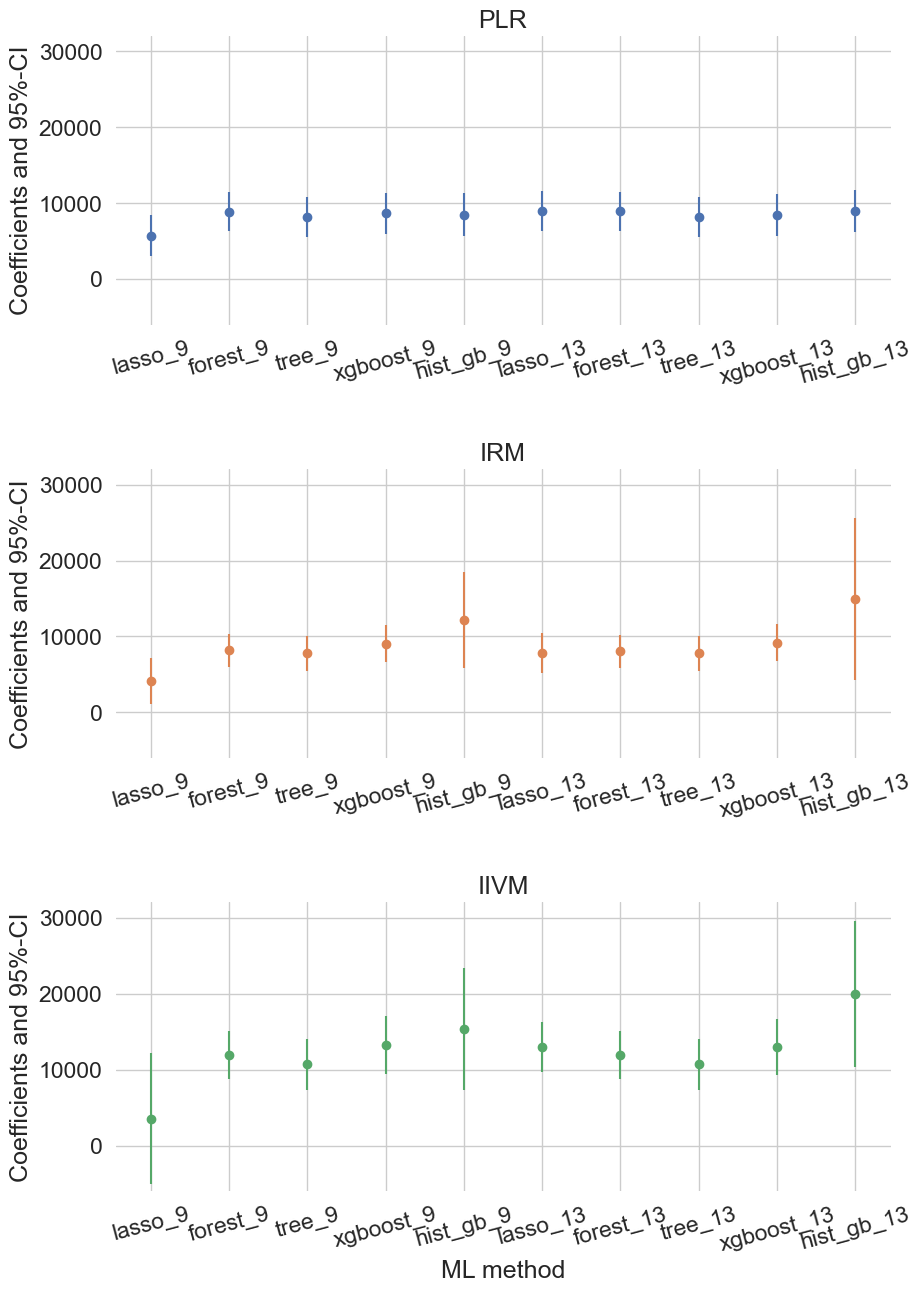

In [7]:
# Plotting PLR results
plt.figure(figsize=(12, 9))
for summary, label in plr_summaries:
    errors = np.full((2, summary.shape[0]), np.nan)
    errors[0, :] = summary['coef'] - summary['2.5 %']
    errors[1, :] = summary['97.5 %'] - summary['coef']
    plt.errorbar(label, summary.coef, fmt='o', yerr=errors, label=label)
plt.xticks(rotation=15)
plt.ylim([2000, 12000])
plt.title('Partially Linear Regression Model (PLR)')
plt.xlabel('ML method')
plt.ylabel('Coefficients and 95%-CI')
plt.savefig('Partially_Linear_Regression_Model.png')
plt.close()

# Plotting IRM results
plt.figure(figsize=(12, 9))
for summary, label in irm_summaries:
    errors = np.full((2, summary.shape[0]), np.nan)
    errors[0, :] = summary['coef'] - summary['2.5 %']
    errors[1, :] = summary['97.5 %'] - summary['coef']
    plt.errorbar(label, summary.coef, fmt='o', yerr=errors, label=label)
plt.xticks(rotation=15)
plt.ylim([0, 25000])
plt.title('Interactive Regression Model (IRM)')
plt.xlabel('ML method')
plt.ylabel('Coefficients and 95%-CI')
plt.savefig('Interactive_Regression_Model.png')
plt.close()

# Plotting IIVM results
plt.figure(figsize=(12, 9))
for summary, label in iivm_summaries:
    errors = np.full((2, summary.shape[0]), np.nan)
    errors[0, :] = summary['coef'] - summary['2.5 %']
    errors[1, :] = summary['97.5 %'] - summary['coef']
    plt.errorbar(label, summary.coef, fmt='o', yerr=errors, label=label)
plt.xticks(rotation=15)
plt.ylim([-6000, 35000])
plt.title('Interactive IV Model (IIVM)')
plt.xlabel('ML method')
plt.ylabel('Coefficients and 95%-CI')
plt.savefig('Interactive_IV_Model.png')
plt.close()

# Combining summaries
plr_summary = pd.concat([summary for summary, label in plr_summaries])
irm_summary = pd.concat([summary for summary, label in irm_summaries])
iivm_summary = pd.concat([summary for summary, label in iivm_summaries])

plr_summary.index = [label for summary, label in plr_summaries]
irm_summary.index = [label for summary, label in irm_summaries]
iivm_summary.index = [label for summary, label in iivm_summaries]

df_summary = pd.concat((plr_summary, irm_summary, iivm_summary)).reset_index().rename(columns={'index': 'ML'})
df_summary['Model'] = np.concatenate((np.repeat('PLR', len(plr_summaries)), np.repeat('IRM', len(irm_summaries)), np.repeat('IIVM', len(iivm_summaries))))
print(df_summary.set_index(['Model', 'ML']))

plt.figure(figsize=(10, 15))
colors = sns.color_palette()
for ind, model in enumerate(['PLR', 'IRM', 'IIVM']):
    plt.subplot(3, 1, ind+1)
    this_df = df_summary.query('Model == @model')
    errors = np.full((2, this_df.shape[0]), np.nan)
    errors[0, :] = this_df['coef'] - this_df['2.5 %']
    errors[1, :] = this_df['97.5 %'] - this_df['coef']
    plt.errorbar(this_df.ML, this_df.coef, fmt='o', yerr=errors, color=colors[ind], ecolor=colors[ind])
    plt.xticks(rotation=15)
    plt.ylim([-6000, 32000])
    plt.title(model)
    plt.ylabel('Coefficients and 95%-CI')
plt.subplots_adjust(hspace=0.5)
plt.xlabel('ML method')
plt.savefig('Combined_Summary.png')
plt.show()
plt.close()
